# Ejercicio 2

## PASO 1 — Simulación del dataset

In [1]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(42)
n = 150

distancia_km = rng.uniform(5, 200, size=n)
peso_kg = rng.uniform(0.5, 50, size=n)
paradas = rng.integers(1, 15, size=n)

ruido = rng.normal(0, 1.5, size=n)

tiempo_entrega_dias = (
    0.05 * distancia_km +
    0.03 * peso_kg +
    0.8 * paradas +
    ruido
)

df = pd.DataFrame({
    "distancia_km": distancia_km,
    "peso_kg": peso_kg,
    "paradas": paradas,
    "tiempo_entrega_dias": tiempo_entrega_dias
})

df.head()


,distancia_km,peso_kg,paradas,tiempo_entrega_dias
0,155.921429,41.401450,9,16.813206
1,90.581296,44.859958,11,16.174600
2,172.426594,7.442330,11,16.056795
3,140.986766,27.924789,2,9.299568
4,23.364583,5.874499,12,13.166647


## PASO 2 — Exploración visual inicial

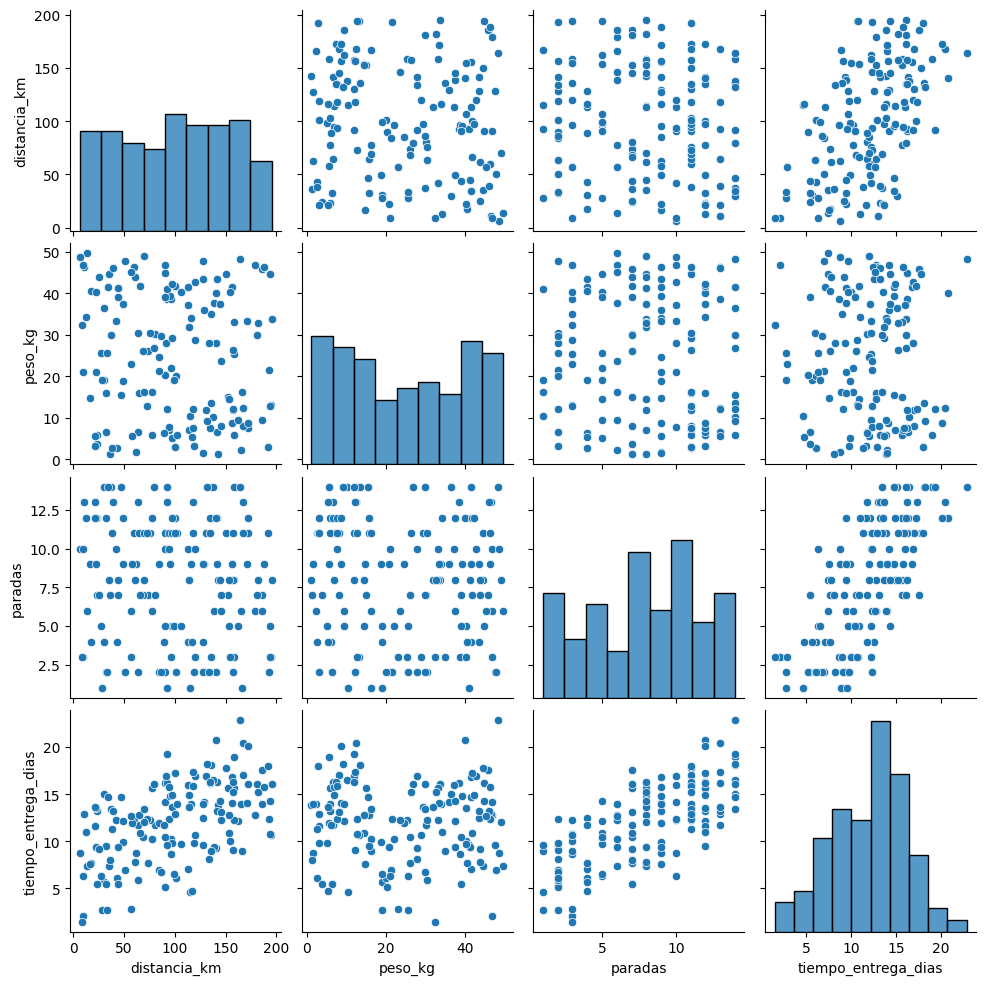

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df)
plt.show()


Relación entre predictores y la variable objetivo

**Distancia vs tiempo de entrega**
* Se ve una tendencia positiva clara
* A mayor distancia, mayor tiempo
* La nube tiene dispersión, pero la dirección es evidente

Esto es justo lo que uno espera en un modelo lineal razonable.

**Peso vs tiempo de entrega**
* La relación es más débil, pero existe
* No es una línea perfecta, pero tampoco es aleatoria

Nota: Probablemente el peso aporte, pero no sea el predictor más fuerte.

**Paradas vs tiempo de entrega**

* Aquí la relación es muy clara y fuerte
* A más paradas, mayor tiempo de entrega
* Se nota casi “por escalones”, porque paradas es una variable discreta

Este gráfico ya nos está diciendo, antes del modelo: paradas va a ser una variable clave.

## PASO 3 — Ajuste del modelo OLS

In [4]:
import statsmodels.api as sm

X = df[["distancia_km", "peso_kg", "paradas"]]
X = sm.add_constant(X)
y = df["tiempo_entrega_dias"]

modelo = sm.OLS(y, X).fit()
print(modelo.summary())


                             OLS Regression Results                            
Dep. Variable:     tiempo_entrega_dias   R-squared:                       0.863
Model:                             OLS   Adj. R-squared:                  0.861
Method:                  Least Squares   F-statistic:                     307.6
Date:                 Thu, 05 Feb 2026   Prob (F-statistic):           6.97e-63
Time:                         16:38:05   Log-Likelihood:                -277.90
No. Observations:                  150   AIC:                             563.8
Df Residuals:                      146   BIC:                             575.8
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0675      0.478    

## PASO 4 — Métricas de desempeño

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = modelo.fittedvalues

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print(f"R²: {modelo.rsquared:.3f}")
print(f"R² ajustado: {modelo.rsquared_adj:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")


R²: 0.863
R² ajustado: 0.861
MAE: 1.226
RMSE: 1.543


* R² = 0.863

El modelo explica aproximadamente el 86 % de la variabilidad del tiempo de entrega.

Con la distancia, el peso y el número de paradas, el modelo logra explicar gran parte de por qué unos pedidos se demoran más que otros.

Es un nivel de explicación alto y satisfactorio para un problema realista de logística.

* R² ajustado = 0.861

El R² ajustado es prácticamente igual al R².

Esto es una muy buena señal porque indica que:

Las variables incluidas sí aportan información

No estamos “inflando” el modelo agregando variables innecesarias

Conclusión:
✔️ El modelo es consistente y no está sobreajustado.

* MAE = 1.226

El MAE indica que, en promedio, el modelo se equivoca en aproximadamente 1.2 días en la predicción del tiempo de entrega.

Interpretación:

Si el modelo dice que un pedido tarda 10 días, en promedio el error será de ±1 día.

Esto suele ser razonable y útil en contextos logísticos reales.

* RMSE = 1.543

El RMSE es un poco mayor que el MAE, lo que es esperable porque penaliza más los errores grandes.

¿Qué nos dice?

Existen algunos errores más altos

Pero no parecen excesivos ni fuera de control

✔️ No hay señales de predicciones inestables o erráticas.

Conclusión:

El modelo presenta un buen desempeño predictivo, con errores promedio moderados y una alta capacidad explicativa.

Las métricas R² y R² ajustado confirman que las variables seleccionadas aportan información relevante, mientras que MAE y RMSE indican que el nivel de error es aceptable para fines prácticos de predicción del tiempo de entrega.

Breve:

“El modelo explica bien el fenómeno y, cuando se equivoca, lo hace por alrededor de un día. No es perfecto, pero es útil y confiable.”

## PASO 5 — Verificación de supuestos

QQ-plot para normalidad del error

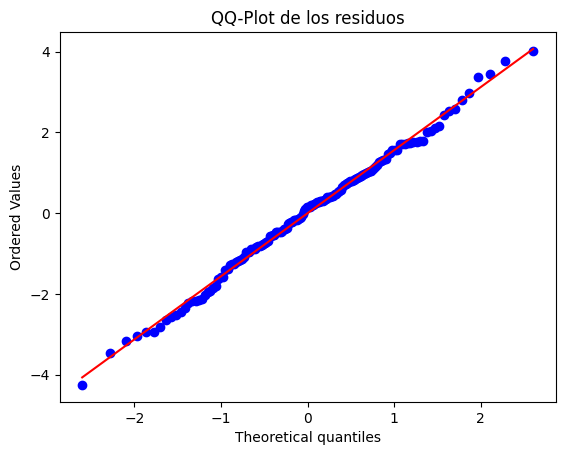

Shapiro-Wilk p-valor: 0.9261


In [6]:
import scipy.stats as stats

residuos = modelo.resid

stats.probplot(residuos, dist="norm", plot=plt)
plt.title("QQ-Plot de los residuos")
plt.show()

shapiro_test = stats.shapiro(residuos)
print(f"Shapiro-Wilk p-valor: {shapiro_test.pvalue:.4f}")


**QQ-plot de los residuos**

* Los puntos siguen muy de cerca la línea roja
* Solo hay leves desviaciones en los extremos, algo normal en datos reales
* No se observan curvaturas fuertes ni colas extrañas

**Test de Shapiro-Wilk**
Resultado obtenido: p-valor = 0.9261

Recordatorio:
* Si p-valor > 0.05, NO se rechaza la normalidad
* Si p-valor < 0.05, hay problemas de normalidad

En este caso:
* 0.9261 es mucho mayor que 0.05

No hay ninguna evidencia estadística contra la normalidad

Homocedasticidad

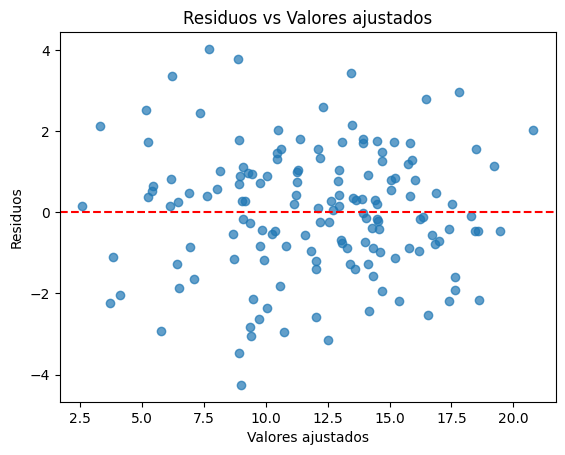

In [7]:
plt.scatter(y_pred, residuos, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Residuos vs Valores ajustados")
plt.show()


En este gráfico:
* Eje X → valores ajustados (las ventas que el modelo predice)
* Eje Y → residuos (qué tanto se equivoca el modelo)
* Línea roja → error cero (cuando el modelo le achunta perfecto)

La pregunta clave es una sola: ¿Los errores mantienen un “ancho” parecido a lo largo de todo el gráfico?

¿Qué se observa en tu gráfico?
* Los puntos están dispersos de forma bastante uniforme
* No se forma un embudo (no se abre ni se cierra)
* No hay una curva clara ni un patrón sistemático
* Los residuos oscilan alrededor de 0 en todo el rango

En otras palabras:
El modelo se equivoca más o menos lo mismo cuando predice valores chicos, medianos o grandes

Multicolinealidad (VIF)

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i)
    for i in range(X.shape[1])
]

vif_data


,Variable,VIF
0,const,14.025143
1,distancia_km,1.024807
2,peso_kg,1.022889
3,paradas,1.018000


El VIF responde a esta pregunta: ¿Esta variable está demasiado “mezclada” con las otras?

Regla práctica:
* VIF ≈ 1 → variable independiente, sin problema
* VIF entre 1 y 5 → aceptable
* VIF > 5 (o 10) → posible problema de multicolinealidad

Conclusión: No existe multicolinealidad relevante entre las variables explicativas del modelo.

## PASO 6 — Comparación de modelos (AIC y BIC)

In [9]:
X_reducido = df[["distancia_km", "paradas"]]
X_reducido = sm.add_constant(X_reducido)

modelo_reducido = sm.OLS(y, X_reducido).fit()

print("Modelo completo:")
print(f"AIC: {modelo.aic:.2f}, BIC: {modelo.bic:.2f}")

print("\nModelo reducido:")
print(f"AIC: {modelo_reducido.aic:.2f}, BIC: {modelo_reducido.bic:.2f}")


Modelo completo:
AIC: 563.79, BIC: 575.84

Modelo reducido:
AIC: 570.40, BIC: 579.43


Recordando:
* Modelo completo:  “El tiempo de entrega depende de la distancia, del peso y del número de paradas.”
* Modelo reducido: “Probar si se puede explicar el tiempo de entrega sin considerar el peso.”

* Un modelo reducido es una versión más simple del modelo original, utilizada para evaluar si es posible eliminar variables sin perder capacidad explicativa, comparando modelos mediante criterios como AIC y BIC.

El modelo completo es mejor que el modelo reducido, ya que presenta menores valores de AIC y BIC, indicando un mejor equilibrio entre ajuste y complejidad.

## PASO 7 — Conclusión final

**Conclusiones relevantes.**

1. Primero, el modelo logra un buen nivel de ajuste.
El R² cercano a 0.86 indica que una parte importante de la variabilidad en el tiempo de entrega puede explicarse a partir de las variables consideradas. Esto sugiere que el modelo es útil desde un punto de vista predictivo.

2. En segundo lugar, los supuestos del modelo se cumplen de forma razonable.
El análisis gráfico de los residuos no muestra patrones sistemáticos, lo que respalda el supuesto de homocedasticidad.
El QQ-plot y el test de Shapiro-Wilk indican que los errores se distribuyen aproximadamente de manera normal.
Además, los valores de VIF cercanos a 1 muestran que no existe un problema de multicolinealidad entre las variables predictoras.

3. Respecto a las variables explicativas, se observa que:
* La distancia recorrida y el número de paradas tienen un efecto claro y significativo sobre el tiempo de entrega.
* El peso del pedido, aunque significativo, aporta una mejora marginal frente al modelo completo.

4. Al comparar el modelo completo con el modelo reducido mediante los criterios AIC y BIC, se observa que el modelo completo presenta valores más bajos, lo que indica un mejor equilibrio entre ajuste y complejidad. Por lo tanto, no conviene eliminar variables relevantes en este caso, ya que hacerlo empeora la calidad global del modelo.

**Conclusión general**

El modelo de regresión lineal múltiple construido es estadísticamente válido, interpretable y consistente con los supuestos teóricos.
En este contexto, el modelo completo es la mejor opción, ya que ofrece un mejor desempeño sin introducir problemas de multicolinealidad ni violaciones graves de los supuestos.

Este ejercicio muestra que validar un modelo no consiste solo en mirar métricas de ajuste, sino en evaluar supuestos, comparar alternativas y justificar decisiones, que es precisamente el objetivo de un buen análisis estadístico